<h1>This pulls data from Worldometers for daily new cases, deaths and recoveries</h1>

<b>Basic Imports</b>

In [94]:
# library imports
import re
import requests
import itertools
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

<b>Regular expression to strip out items before and after colon</b>

In [95]:
REGEX = re.compile('\n^(.*?):(.*?)$|,', re.MULTILINE) #compile regex

<b>Functions used to create the datablocks that we care about, specifically new cases, deaths and recoveries</b>

In [96]:
def createDataBlock(full_html, regex):
    js_text = re.findall(regex, full_html) #  find first item @ new line to : and 2nd item @ from : to the end of the line or , 
    test = [[jt_tuple.strip() for jt_tuple in jt_array] for jt_array in js_text]
    
    all_categories = [x for x in test if x[0] != '']
    datablock = [x for x in test if x[0] == 'categories' or x[0] == 'data' or x[0] == 'name']
    data_string = datablock[2][1]
    cat_string = datablock[0][1]
    name_string = datablock[1][1]
    
    # clean up data and categories
    data = re.sub('[\s+\[\]{}]', '', data_string)[0:-1].split(',')
    data = [0 if x=='null' else x for x in data]
    data = list(map(int,data))
    cats = re.sub('["+\[\]{}\s+]', '', cat_string).split(',')
    cats = [x for x in cats if x != '']
    name = re.sub('[\',+]', '', name_string)
    
    dataarray = [name, cats, data]
    return dataarray

In [220]:
def getCountryData(country):
    url = "https://www.worldometers.info/coronavirus/country/"+country
    soup = BeautifulSoup(requests.get(url).content,"html.parser")
    
    # strip out all Highcharts data for specific events
    full_html_daily_cases = soup.find_all('script', type="text/javascript",text=re.compile("graph-cases-daily"))[0].text
    full_html_daily_deaths = soup.find_all('script', type="text/javascript",text=re.compile("graph-deaths-daily"))[0].text
    full_html_daily_cured = soup.find_all('script', type="text/javascript",text=re.compile("cases-cured-daily"))[0].text
    
    cases = createDataBlock(full_html_daily_cases, REGEX)
    deaths = createDataBlock(full_html_daily_deaths, REGEX)
    recoveries = createDataBlock(full_html_daily_cured, REGEX)
    
    df = pd.DataFrame(list(zip(cases[1], cases[2], deaths[2], recoveries[2])), 
                     columns = ['Date','Cases','Deaths','Recoveries'])
    
    df.set_index('Date', inplace=True)
    df.replace("nan",0,inplace=True)
    df['Active'] = df['Cases']-df['Deaths']-df['Recoveries']
    
    cumdf = df.cumsum()
    cumdf = cumdf[cumdf['Active']>100]
    cumdf['Active_Chg_Pct_D'] = cumdf['Active']/cumdf['Active'].shift(1)-1
    
    return df, cumdf

<b>We can pull data from https://www.worldometers.info/coronavirus/#countries using the function getCountryData(country_name)</b>

<b>Countries: us, italy, china, south-korea, spain, etc...</b> 

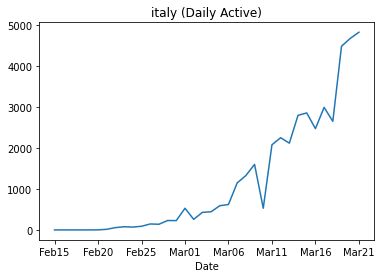

In [221]:
w,h = (12,7)
country_name = 'italy'
df,cumdf = getCountryData(country_name)
df['Active'].plot(title=country_name+' (Daily Active)')

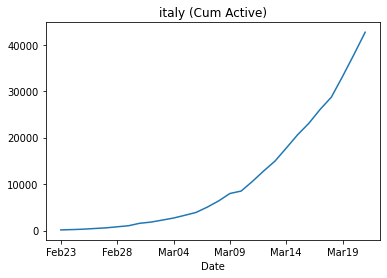

In [227]:
cumdf['Active'].plot(title=country_name+' (Cum Active)')

In [217]:
#cumdf['Active'].plot(title=country_name+" (Cum Active)")

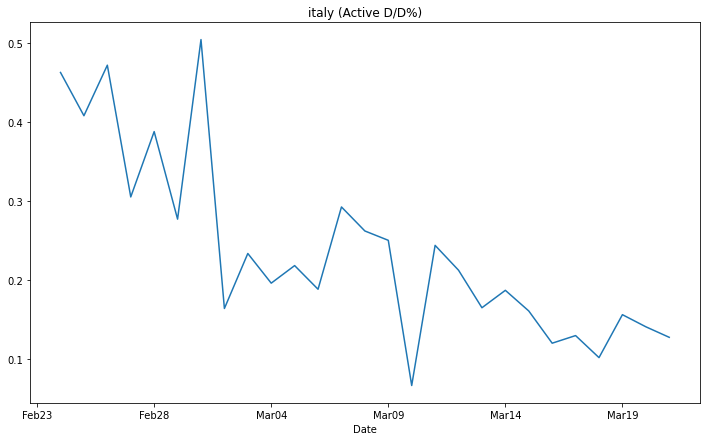

In [223]:
cumdf['Active_Chg_Pct_D'].plot(figsize=(w,h),kind='line',title=country_name+" (Active D/D%)")

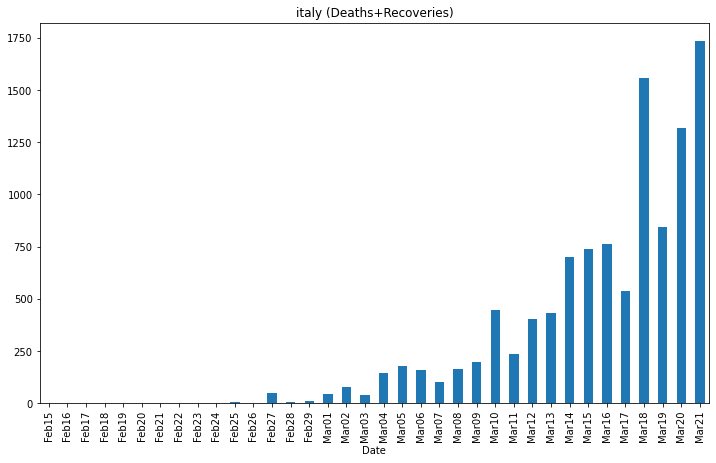

In [226]:
(df['Recoveries']+df['Deaths']).plot(figsize=(w,h),kind='bar',title=country_name+" (Deaths+Recoveries)")

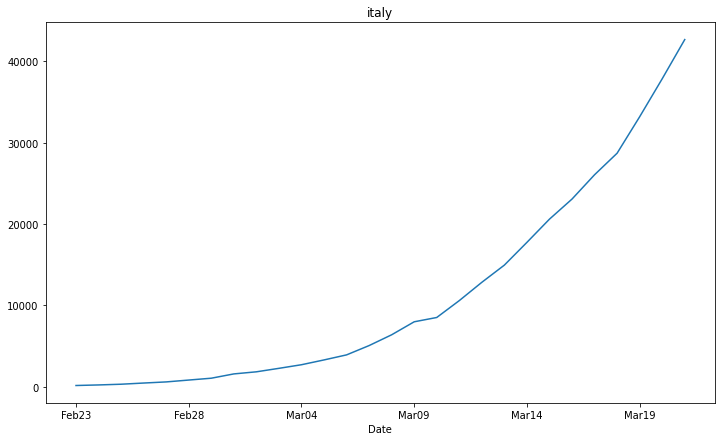

In [228]:
cumdf[cumdf['Active']>100]['Active'].plot(title=country_name,figsize=(w,h))

In [229]:
cumdf[-10:]

,Cases,Deaths,Recoveries,Active,Active_Chg_Pct_D
Date,,,,,
Mar12,15110,1016,1258,12836,0.212430
Mar13,17657,1266,1439,14952,0.164849
Mar14,21154,1441,1966,17747,0.186932
Mar15,24744,1809,2335,20600,0.160760
Mar16,27977,2158,2749,23070,0.119903
Mar17,31503,2503,2941,26059,0.129562
Mar18,35710,2978,4025,28707,0.101616
Mar19,41032,3405,4440,33187,0.156059
Mar20,47018,4032,5129,37857,0.140718
